In [ ]:
# Resources used

# https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
# Data augmentation
# http://cv-tricks.com/artificial-intelligence/object-detection-using-deep-learning-for-advanced-users-part-1/

# scene recognition, domain adaptation, and fine-grained recognition

In [3]:
# base_model = InceptionV3(weights='imagenet', include_top=False)

In [4]:
IM_WIDTH, IM_HEIGHT = 256, 256 

In [6]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# from selectivesearch import selective_search
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.output

<tf.Tensor 'mixed10/concat:0' shape=(?, ?, ?, 2048) dtype=float32>

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='rmsprop',    
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
# x, y = train_generator.next()

## Load data 


In [13]:
import os
# pip install Pillow
from PIL import Image 
datadir = '../data/ig/'

In [14]:
def PIL2array(img):
    return np.array(img.getdata(),
                    np.uint8).reshape(img.size[1], img.size[0], 3)

In [17]:
all_img = []

print("Total number of images: {}".format(len(os.listdir(datadir))))

for i, f in enumerate(os.listdir(datadir)):
    if (i % 100) == 0: 
        print(i)
    f = os.path.join(datadir, f)
    img = Image.open(f)
    img = PIL2array(img).astype(np.float)
    img -= 128
    img /= 127
    
    all_img.append(img)

Total number of images: 7303
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300


In [18]:
X = np.array(all_img)[[(x.shape == (IM_WIDTH, IM_HEIGHT, 3)) for x in all_img]]

X_2 = np.zeros(shape=(len(X), IM_WIDTH, IM_HEIGHT, 3))
for i, x in enumerate(X):
    X_2[i] = x
    
X = X_2

In [19]:
X.shape

(7233, 256, 256, 3)

## Predicting latent variables

In [20]:
print("predicting...")
pred = model.predict(X)

predicting...


## PCA

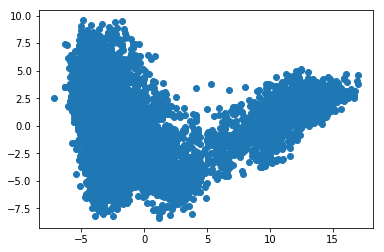

In [21]:
pca = PCA(32)
pred_t = pca.fit_transform(pred)
plt.scatter(pred_t[:,0], pred_t[:,2])

In [22]:
from sklearn.neighbors import KDTree

In [23]:
eval_pt_vec = [195, 51, 659, 3176, 2595, 2299, 1708, 542, 862, 1324, 1382]


## Nearest neighbour search

In [ ]:
ii = 0
# eval_pt = eval_pt_vec[ii]
ii += 1
eval_pt = np.random.randint(0, len(pred_t))

print(eval_pt)
tree = KDTree(pred_t, leaf_size=2)
dist, ix_arr = tree.query(pred_t, k=9)

# print(ix_arr)

count = 0
for i, ix in enumerate(ix_arr[eval_pt]):
    count += 1
    img = X[ix]
    img = (img + 1.1)/2.1
    plt.figure()
    plt.imshow(img)
    plt.title(dist[eval_pt, i])
    if count > 10:
        break

6502


## Junk

In [157]:
# km = KMeans(n_clusters=15)
# clusters = km.fit_predict(pred_t)

In [ ]:
# clus_contents = x[clusters == np.argmax(np.bincount(clusters))]

# for clus_id in range(0, np.max(clusters)):

#     clus_str = "=== CLUSTER {} ===".format(clus_id)
#     clus_contents = X[clusters == clus_id]

#     for img in clus_contents:
#         img = (img + 1)/2
#         plt.figure()
#         plt.title(clus_str)
#         plt.imshow(img)


In [ ]:
def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Args:
        base_model: keras model excluding top
        nb_classes: # of classes
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x) 
    predictions = Dense(nb_classes, activation='softmax')(x) 
    model = Model(input=base_model.input, output=predictions)
    return model

In [ ]:
model = add_new_last_layer(base_model, 5)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='rmsprop',    
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model_fitted = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
#    validation_data=validation_generator,
#    nb_val_samples=nb_val_samples,
    class_weight='auto',
    verbose=2)

In [ ]:
model_fitted.params

## Selective search

In [ ]:
x, y = train_generator.next()
img = (x[0] + 1) / 2.
img_lbl, regions = selectivesearch.selective_search(img, scale=100, sigma=0.9, min_size=512)

In [ ]:
plt.figure()
plt.imshow(img)
ax = plt.gca()

rects = [r['rect'] for r in regions]

for x, y, w, h in rects:
# #     print(x, y, w, h)     
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)


In [ ]:
r

## Test train generation 

In [ ]:
x, y = train_generator.next()
x = (x[0] + 1) / 2.

In [ ]:
plt.imshow(x)

In [ ]:
# for i, x in enumerate(train_datagen):
#     x
#     if i == 1:
#         break